## Portfolio Management | Portfolio Optimization

- Portfolio management
- Mean-variance portfolio optimization (Efficient Frontier, Global Minimum Variance, Tangency Portfolio)

Assume we have $n$ assets and their expected return column vector is $\mu$ and their covariance matrix is $\Sigma$. Then the return and variance of a portfolio that invests in these n assets with weight $w$ are, respectively, $$\mu_p = w^T \mu$$ $$\sigma_p^2 = w^T \Sigma w$$ In addition, the covariance between two portfolios of respective weights $w_1$ and $w_2$, is $$\rho_{12} = cov(w_1^T \mu, w_2^T \mu) = w_1^T \Sigma w_2$$

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
assets = ['AAPL',       # Apple
          'KO',         # Coca-Cola
          'DIS',        # Disney
          'XOM',        # Exxon Mobil
          'JPM',        # JPMorgan Chase
          'MCD',        # McDonald's
          'WMT']         # Walmart

# download historical data
hist_data = {}
for ticker in assets:
    try:
        stock = yf.Ticker(ticker)
        df = stock.history(start='2015-01-01', end='2017-12-31')
        hist_data[ticker] = df['Close']  
    except Exception as e:
        print(f"Failed to get {ticker}: {e}")

hist_data = pd.DataFrame(hist_data)

# calculate historical log returns
hist_return = np.log(hist_data / hist_data.shift())
hist_return = hist_return.dropna()

# find historical mean, covriance, and correlation
hist_mean = hist_return.mean(axis=0).to_frame()
hist_mean.columns = ['mu']
hist_cov = hist_return.cov()
hist_corr = hist_return.corr()
print(hist_mean.transpose())
print(hist_cov)
print(hist_corr)

        AAPL        KO       DIS       XOM       JPM       MCD       WMT
mu  0.000652  0.000242  0.000238  0.000002  0.000808  0.000932  0.000293
          AAPL        KO       DIS       XOM       JPM       MCD       WMT
AAPL  0.000208  0.000032  0.000055  0.000051  0.000076  0.000044  0.000038
KO    0.000032  0.000065  0.000030  0.000033  0.000032  0.000035  0.000030
DIS   0.000055  0.000030  0.000138  0.000048  0.000072  0.000032  0.000031
XOM   0.000051  0.000033  0.000048  0.000132  0.000080  0.000036  0.000028
JPM   0.000076  0.000032  0.000072  0.000080  0.000180  0.000051  0.000038
MCD   0.000044  0.000035  0.000032  0.000036  0.000051  0.000101  0.000032
WMT   0.000038  0.000030  0.000031  0.000028  0.000038  0.000032  0.000150
          AAPL        KO       DIS       XOM       JPM       MCD       WMT
AAPL  1.000000  0.277771  0.324263  0.308124  0.390815  0.305937  0.215722
KO    0.277771  1.000000  0.313573  0.357595  0.293827  0.426696  0.307809
DIS   0.324263  0.313573  1.0

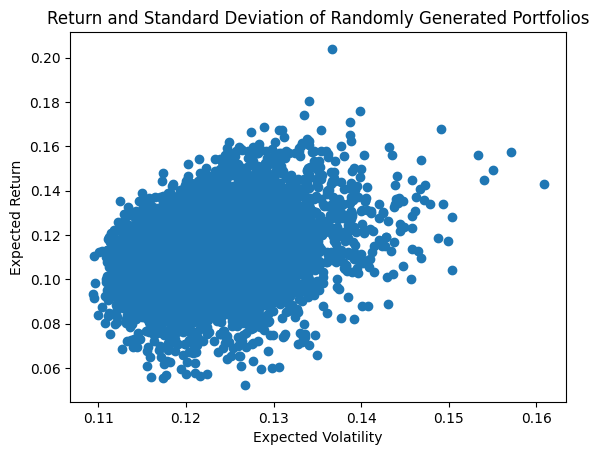

In [3]:
# construct random portfolios
n_portfolios = 5000
#set up array to hold results
port_returns = np.zeros(n_portfolios)
port_stdevs = np.zeros(n_portfolios)

for i in range(n_portfolios):
    w = np.random.rand(len(assets))        # random weights
    w = w / sum(w)                         # weights sum to 1
    port_return = np.dot(w.T, hist_mean.values.flatten()) * 250         # annualize; 250 business days
    port_stdev = np.sqrt(np.dot(w.T, np.dot(hist_cov, w))) * np.sqrt(250)  # annualize; 250 business days
    port_returns[i] = port_return
    port_stdevs[i] = port_stdev

plt.plot(port_stdevs, port_returns, 'o', markersize=6)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Return and Standard Deviation of Randomly Generated Portfolios')
plt.show()

## 1.Global Minimum Variance (GMV)

To find the GMV, we need to solve
$$
\min \quad \sigma^2 = w^T \Sigma w 
\quad \text{s.t.} \quad w^T \mathbf{1} = 1
$$
The Lagrangian for this problem is
$$
L(w, \lambda) = w^T \Sigma w + \lambda (w^T \mathbf{1} - 1)
$$
and its first order condition is
$$
\frac{\partial L}{\partial w} = w^T (\Sigma + \Sigma^T) + \lambda \mathbf{1}^T = 0
$$
$$
\frac{\partial L}{\partial \lambda} = w^T \mathbf{1} - 1 = 0
$$
To solve this system of two equations, first we solve for w from the first equation
$$
w = -\frac{1}{2} \lambda \Sigma^{-1} \mathbf{1}
$$
Then we put it into the second equation to solve $\lambda$,
$$
w^T \mathbf{1} = \left( -\frac{1}{2} \lambda \mathbf{1}^T \Sigma^{-1} \right) \mathbf{1} = 1 \\
\Rightarrow \quad \lambda = -\frac{2}{\mathbf{1}^T \Sigma^{-1} \mathbf{1}}
$$
Finally substitute $\lambda$ back to solve for the optimal $w$
$$
w^* = \frac{\Sigma^{-1} \mathbf{1}}{\mathbf{1}^T \Sigma^{-1} \mathbf{1}}
$$

In [4]:
# Global Minimum Variance (GMV) -- closed form
hist_cov_inv = - np.linalg.inv(hist_cov)
one_vec = np.ones(len(assets))
w_gmv = np.dot(hist_cov_inv, one_vec) / (np.dot(np.transpose(one_vec), np.dot(hist_cov_inv, one_vec)))
w_gmv_df = pd.DataFrame(data = w_gmv).transpose()
w_gmv_df.columns = assets
stdev_gmv = np.sqrt(np.dot(w_gmv.T, np.dot(hist_cov, w_gmv))) * np.sqrt(250)
print(w_gmv_df)
print(stdev_gmv)

       AAPL        KO       DIS       XOM       JPM       MCD       WMT
0  0.037916  0.426977  0.125361  0.115104 -0.014246  0.179345  0.129543
0.10748227107344319


## 2.Efficient Portfolio

To find an efficient portfolio other than GMV, we face a dual optimization problem. The primary problem finds highest return given a certain risk level $\sigma_0$
$$
\begin{aligned}
\max \quad & \mu_p = w^{T}\mu \\
\text{s.t.}\quad & \sigma_p^{2}=w^{T}\Sigma w = \sigma_{0},\\
                 & w^{T}\mathbf{1}=1
\end{aligned}
$$
while its dual finds the minimum risk given a certain return level $\mu_0$
$$
\begin{aligned}
\min \quad & \sigma_p^{2}=w^{T}\Sigma w \\
\text{s.t.}\quad & \mu_p = w^{T}\mu = \mu_{0},\\
                 & w^{T}\mathbf{1}=1
\end{aligned}
$$

It is more common to solve the dual minimization problem (3.2), whose Lagrangian function is given by
$$
L(w,\lambda_1,\lambda_2)=w^{T}\Sigma w + \lambda_1\left(w^{T}\mu-\mu_{0}\right) + \lambda_2\left(w^{T}\mathbf{1}-1\right)
$$
and its first order condition is
$$
\begin{aligned}
2\Sigma w + \lambda_1 \mu + \lambda_2 \mathbf{1} &= 0,\\
w^{T}\mu-\mu_{0}&=0,\\
w^{T}\mathbf{1}-1&=0.
\end{aligned}
$$
Similarily, from the first equation we have
$$
w \;=\; -\frac12 \lambda_1 \Sigma^{-1}\mu \;-\; \frac12 \lambda_2 \Sigma^{-1}\mathbf{1}
$$
$$
-\frac12
\begin{pmatrix}
\mu^{T}\Sigma^{-1}\mu & \mu^{T}\Sigma^{-1}\mathbf{1}\\
\mathbf{1}^{T}\Sigma^{-1}\mu & \mathbf{1}^{T}\Sigma^{-1}\mathbf{1}
\end{pmatrix}
\begin{pmatrix}
\lambda_1\\
\lambda_2
\end{pmatrix} =
\begin{pmatrix}
\mu_{0}\\
1
\end{pmatrix}
$$
which yields
$$
A \;=\;
\begin{pmatrix}
\mu^{T}\Sigma^{-1}\mu & \mu^{T}\Sigma^{-1}\mathbf{1}\\
\mathbf{1}^{T}\Sigma^{-1}\mu & \mathbf{1}^{T}\Sigma^{-1}\mathbf{1}
\end{pmatrix},\qquad
y \;=\;
\begin{pmatrix}
\mu_{0}\\
1
\end{pmatrix}
$$
$$
\lambda \;=\;
\begin{pmatrix}\lambda_1\\\lambda_2\end{pmatrix}
= -2A^{-1}y
$$
In the end, substitute $\lambda$ back to solve for the optimal w as
$$
B \;=\;
\begin{bmatrix}
\mu & \mathbf{1}
\end{bmatrix},\qquad
w^{*}
= -\frac12 \Sigma^{-1}B\lambda
= \Sigma^{-1} B A^{-1} y
$$

In [5]:

from cvxopt import matrix, solvers
import numpy as np
import pandas as pd

# ---------- Inputs from previous steps ----------
# `hist_cov` : DataFrame of the sample covariance matrix Σ (n × n)
# `hist_mean`: DataFrame of sample means μ          (n × 1)
# `assets`   : list of ticker symbols (length n)

Sigma   = hist_cov.values                    # (n × n) → NumPy array
mu_vec  = hist_mean.values.flatten()         # (n,)     → 1-D array
one_vec = np.ones(len(assets))               # (n,)     → 1-D array of ones

# Target return μ₀  – here we pick the largest sample mean
mu_o = mu_vec.max()

# ---------- Build QP parameters ----------
# Objective: (1/2) wᵀ P w  +  qᵀ w   with q = 0  (we only care about variance)
P = matrix(Sigma)                            # cvxopt matrix, must be PSD
q = matrix(np.zeros(len(assets)))            # zero linear term

# Equality constraints:  A w = b
#    row-1 enforces target return, row-2 enforces full investment
A = np.vstack([mu_vec, one_vec])             # shape (2, n)
A = matrix(A)
b = matrix(np.array([mu_o, 1.0]))            # shape (2,)

# ---------- Solve the QP ----------
# Without short-selling constraints
solution = solvers.qp(P, q, A=A, b=b)

# ---------- Retrieve optimal weights ----------
w_max_ret = np.array(solution['x']).flatten()   # (n,) optimal weights

# ---------- Wrap into a neat DataFrame ----------
w_max_ret_df = pd.DataFrame([w_max_ret], columns=assets)
print(w_max_ret_df.round(4))

     AAPL      KO     DIS     XOM     JPM     MCD     WMT
0  0.1043  0.1843 -0.0097 -0.2388  0.2498  0.6449  0.0653


## 3.Efficient Frontier

The previous section finds the minimum risk portfolio for a given return level. When we traverse all possible return levels, we get a set of optimal portfolios known as efficient frontier.

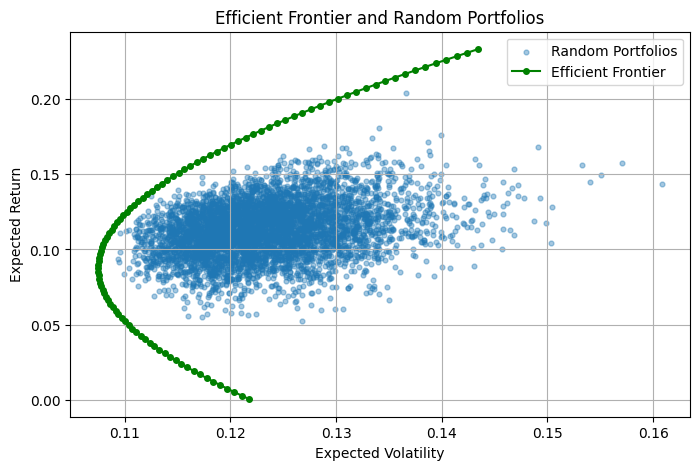

In [6]:
from cvxopt import matrix, solvers
import numpy as np
import matplotlib.pyplot as plt

# -------- 1. basic inputs (already computed earlier) --------
Sigma      = hist_cov.values              # n×n
Sigma_inv  = np.linalg.inv(Sigma)
mu_vec     = hist_mean.values.flatten()   # (n,)
one_vec    = np.ones_like(mu_vec)         # (n,)

P = matrix(Sigma)                         # QP: ½ wᵀPw
q = matrix(np.zeros(len(mu_vec)))         #      + qᵀw

# -------- 2. left & right ends of frontier --------
ef_left  = mu_vec.min().item()            # smallest sample mean
ef_right = mu_vec.max().item()            # largest  sample mean
N = 100                                   # how many target returns
target_returns = np.linspace(ef_left, ef_right, N)

# -------- 3. solve QP for each target return --------
A_tpl = np.vstack([mu_vec, one_vec])      # 2×n, does NOT change in loop
A_cvx = matrix(A_tpl)

weights = []
for t in target_returns:
    b_cvx = matrix([t, 1.0])              # target return = t, full budget = 1
    sol   = solvers.qp(P, q, A=A_cvx, b=b_cvx, options={'show_progress': False})
    w     = np.array(sol['x']).flatten()  # convert to 1-D NumPy
    weights.append(w)

# -------- 4. compute annualised risk / return for those weights --------
ef_returns = [w @ mu_vec * 250                for w in weights]
ef_risks   = [np.sqrt(w @ Sigma @ w * 250)    for w in weights]

# -------- 5. plot: random portfolios + efficient frontier --------
plt.figure(figsize=(8,5))
plt.scatter(port_stdevs, port_returns, s=12, alpha=0.4,
            label='Random Portfolios')
plt.plot(ef_risks, ef_returns, color='green', marker='o',
         markersize=4, label='Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Random Portfolios')
plt.legend()
plt.grid(True)
plt.show()


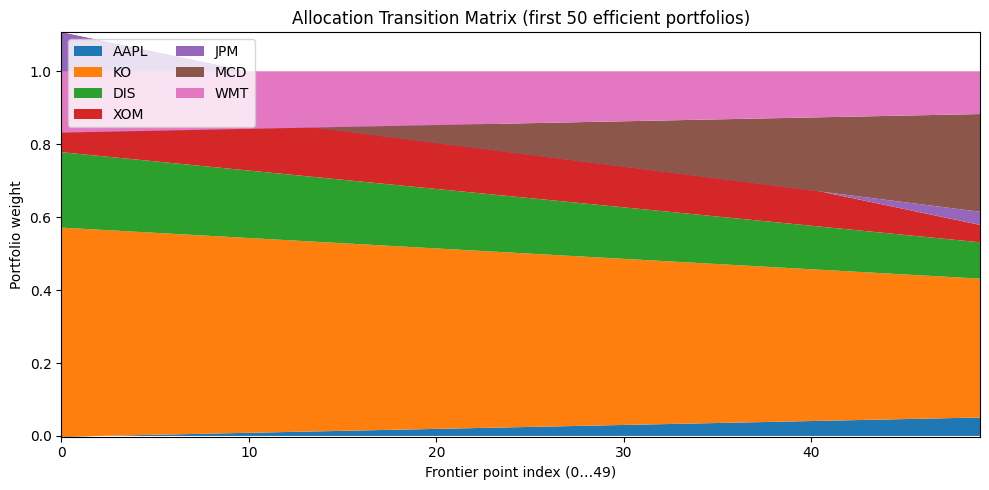

In [7]:
transition_data = pd.DataFrame(weights, columns=assets)    # shape (N, n)

# ---------- choose the first 50 target-return points ----------
K = 50                                  # how many points to show
x_axis = np.arange(K)                   # 0,1,2,…,K-1   (same length as the slice)
y_stack = transition_data.iloc[:K, :].T # shape (n, K) for stackplot

plt.figure(figsize=(10, 5))
plt.stackplot(x_axis, y_stack.values, labels=assets)
plt.margins(0, 0)                         # remove default margins
plt.legend(loc="upper left", ncol=2)      # ncol=2 keeps it compact
plt.xlabel("Frontier point index (0…49)")
plt.ylabel("Portfolio weight")
plt.title("Allocation Transition Matrix (first 50 efficient portfolios)")
plt.tight_layout()
plt.show()

## 4.Tangency Portfolio

It maximizes Sharpe Ratio.
Denote risk free interest rate as $r_f$, tangency portfolio targets the following equation,
$$
\begin{aligned}
\max \;& \frac{\mu_p - r_f}{\sigma_p}
      \;=\;
      \frac{w^{T}\mu - r_f}{\bigl(w^{T}\Sigma w\bigr)^{1/2}}
\\[4pt]
\text{s.t.}\;&
w^{T}\mathbf{1} = 1
\end{aligned}
$$
First, note that the ojective function is invariant with respect to leverage. In other words, it remains the same if we double the weight $w$. Therefore the contraint can be ignored as long as $w$ will be normalized in the end.
Secondly, if we knew the expected return $r_0$ of the tangent portfolio, it must satisfy the following:
$$
\begin{aligned}
\max \;& w^{T}\Sigma w \\[4pt]
\text{s.t.}\;&
w^{T}(\mu - r_f\mathbf{1}) = r_0
\end{aligned}
$$
Solving this similarily to the previous section, it gives
$$
w
=\;
\frac{\,r_0\,}
       {(\mu - r_f\mathbf{1})^{T}\Sigma^{-1}(\mu - r_f\mathbf{1})}
\;\bigl(\Sigma^{-1}(\mu - r_f\mathbf{1})\bigr)
$$
By normalizing it, the arbitrary target expected return $r_0$ actually goes away, leaving the optimal allocation as
$$
w^{*}
=\;
\frac{\Sigma^{-1}(\mu - r_f\mathbf{1})}
     {\mathbf{1}^{T}\Sigma^{-1}(\mu - r_f\mathbf{1})}
$$


In [9]:
# ---------- inputs ----------
Sigma      = hist_cov.values              # covariance Σ (n×n)
Sigma_inv  = np.linalg.inv(Sigma)         # Σ⁻¹
mu_vec     = hist_mean.values.flatten()   # μ  (n,)  daily mean return
one_vec    = np.ones(len(mu_vec))         # 1  (n,)
r_f        = 0.01                         # annual risk-free rate (1%)

# convert r_f to *daily* to match μ
excess_mu  = mu_vec - r_f / 250.0         # μ − r_f·1   (n,)

# ---------- closed-form tangency weights ----------
w_raw      = Sigma_inv @ excess_mu                       # numerator  (n,)
w_sharpe   = w_raw / (one_vec @ w_raw)                   # normalize so Σ w_i = 1

# ---------- pack into a DataFrame for readability ----------
w_sharpe_df = pd.DataFrame([w_sharpe], columns=assets)
print("Tangency-portfolio weights (sum = 1):")
print(w_sharpe_df.round(4))

# ---------- portfolio stats (annualised) ----------
mu_sharpe    = (w_sharpe @ mu_vec) * 250                # expected return
stdev_sharpe = np.sqrt(w_sharpe @ Sigma @ w_sharpe) * np.sqrt(250)
sharpe_ratio = (mu_sharpe - r_f) / stdev_sharpe

print(f"\nμ  (expected return)   : {mu_sharpe:.4f}")
print(f"σ  (volatility)        : {stdev_sharpe:.4f}")
print(f"Sharpe ratio           : {sharpe_ratio:.4f}")


Tangency-portfolio weights (sum = 1):
     AAPL      KO     DIS     XOM     JPM     MCD     WMT
0  0.1961 -0.1513 -0.1965 -0.7281  0.6148  1.2885 -0.0236

μ  (expected return)   : 0.4333
σ  (volatility)        : 0.2504
Sharpe ratio           : 1.6903
